In [1]:
#%matplotlib notebook
import os
import matplotlib.pyplot as plt
import numpy as np
from JSAnimation import IPython_display
from matplotlib import animation
import matplotlib.patches as mpatches
import cv2
import scipy.misc
import tensorflow as tf
import tensorflow.contrib.layers as c_layers
import seaborn as sns
import pandas as pd
import glob
from scipy import misc
from keras.preprocessing.image import ImageDataGenerator

c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:5

Instructions for updating:
Use the retry module or similar alternatives.


Using TensorFlow backend.


## Load Data

In [293]:
path = "./Results/TowerTraining/Recordings/Standard/3999_16.100/"
figure_path = './Results/TowerTraining/Figures/NNFiguresSameOpt/Robustness/'
obs = np.load(path+"visobs.npy")
vec = np.load(path+"vecobs.npy")
actions = np.load(path+"actions.npy")[:,0,:]
enc = np.load(path+"encodings.npy")[:,0,:256]

## Load Agent

In [104]:
class CNN(object):

    def __init__(self, model_filepath):

        # The file path of model
        self.model_filepath = model_filepath
        # Initialize the model
        self.load_graph(model_filepath = self.model_filepath)

    def load_graph(self, model_filepath):
        '''
        Lode trained model.
        '''
        print('Loading model...')
        self.graph = tf.Graph()

        with tf.gfile.GFile(model_filepath, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())

        #print('Check out the input placeholders:')
        #nodes = [n.name + ' => ' +  n.op for n in graph_def.node if n.op in ('Placeholder')]
        #for node in nodes:
        #    print(node)

        with self.graph.as_default():
            self.VisInput = tf.placeholder(shape=[None, 168, 168, 3], dtype=tf.float32,name="visual_observation_0")
            self.VecInput = tf.placeholder(shape=[None, 8], dtype=tf.float32,name='vector_observation')
            self.action_masks = tf.placeholder(shape=[None, 11], dtype=tf.float32, name="action_masks")
            tf.import_graph_def(graph_def, {'visual_observation_0': self.VisInput,
                                            'vector_observation': self.VecInput,
                                            'action_masks':self.action_masks})
            #self.init = tf.global_variables_initializer()

        self.graph.finalize()

        print('Model loading complete!')

        # Get layer names
        #layers = [op.name for op in self.graph.get_operations()]
        #for layer in layers:
        #    print(layer)
        
        """
        # Check out the weights of the nodes
        weight_nodes = [n for n in graph_def.node if n.op == 'Const']
        for n in weight_nodes:
            print("Name of the node - %s" % n.name)
            # print("Value - " )
            # print(tensor_util.MakeNdarray(n.attr['value'].tensor))
        """

        # In this version, tf.InteractiveSession and tf.Session could be used interchangeably. 
        #self.sess = tf.InteractiveSession(graph = self.graph)
        self.sess = tf.Session(graph = self.graph)
        
        #self.sess.run(self.init)

    def test(self, visIn, vecIn, ActMask):
        #'dense/kernel:0', 'dense_1/kernel:0', 'dense_2/kernel:0', 'dense_3/kernel:0', 'dense_4/kernel:0'

        # Know your output node name
        output_tensor = self.graph.get_tensor_by_name("import/action:0")
        enc_tensor = self.graph.get_tensor_by_name('import/concat:0')
        output = self.sess.run([output_tensor, enc_tensor], feed_dict = {self.VisInput: visIn, self.VecInput: vecIn, self.action_masks: ActMask})

        return output


In [105]:
def test_from_frozen_graph(obs,model_filepath):
    tf.reset_default_graph()
    model = CNN(model_filepath = model_filepath)
    print('loaded')
    
    actOut, enc2 = model.test(visIn = obs, vecIn= vec[0],ActMask = np.ones((obs.shape[0],11)))
    return actOut, enc2

a,e = test_from_frozen_graph(obs,'./Results/TowerTraining/models/TowerF4/TowerF4_Baseline-0/LearningBrain/frozen_graph_def.pb')

Loading model...
Model loading complete!
loaded


In [134]:
def probsToLabels(probs):
    Ls = []
    for p in probs:
        L = np.zeros(4)
        L[0] = int(np.argmax(p[:3]))
        L[1] = int(np.argmax(p[3:6]))
        L[2] = int(np.argmax(p[6:8]))
        L[3] = int(np.argmax(p[8:]))
        Ls.append(L)
    return np.array(Ls)
actOut2 = probsToLabels(a)

## Generate Noisy Images

In [44]:
from skimage.util import random_noise

In [312]:
noise_imgs = random_noise(obs, mode='gaussian', var=0.005,seed=None, clip=True)

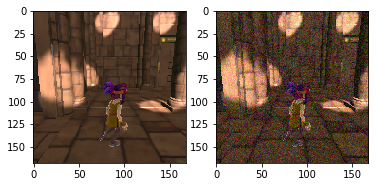

In [313]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(obs[5])
plt.subplot(1,2,2)
plt.imshow(noise_imgs[5])
plt.show()

In [314]:
a_noise,e_noise = test_from_frozen_graph(noise_imgs,'./Results/TowerTraining/models/TowerF4/TowerF4_Baseline-0/LearningBrain/frozen_graph_def.pb')
a_noise_l = probsToLabels(a_noise)

Loading model...
Model loading complete!
loaded


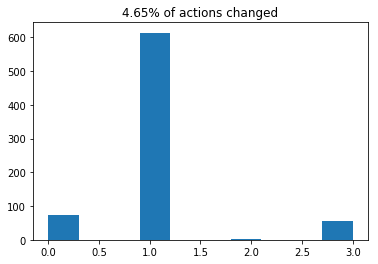

In [315]:
plt.hist(np.where(actOut != a_noise_l)[1])
plt.title(str(np.where(actOut != a_noise_l)[1].shape[0]/(actOut.shape[0]*4)*100)+'% of actions changed')
plt.show()

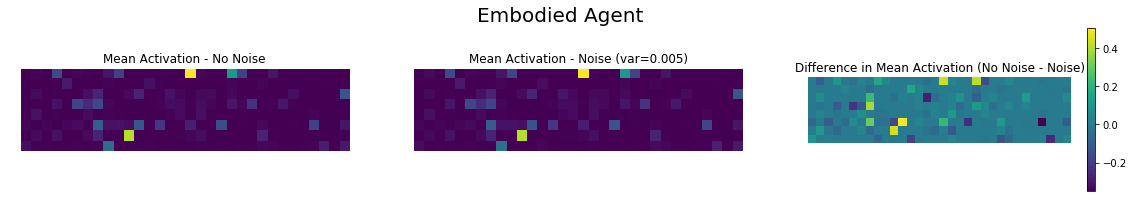

In [316]:
plt.figure(figsize=(20,3))
plt.suptitle('Embodied Agent',fontsize=20)
plt.subplot(1,3,1)
plt.imshow(np.mean(e,axis=0).reshape((8,32)))
plt.title('Mean Activation - No Noise')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(np.mean(e_noise,axis=0).reshape((8,32)))
plt.title('Mean Activation - Noise (var=0.005)')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.mean(e-e_noise,axis=0).reshape((8,32)))
plt.title('Difference in Mean Activation (No Noise - Noise)')
plt.axis('off')
plt.colorbar()
plt.show()

## Load Classifier

In [183]:
tf.reset_default_graph()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

o_size_h = 168
o_size_w = 168
vec_obs_size = 8
num_layers = 2
h_size = 256
h_size_vec = 256
            
visual_in = tf.placeholder(shape=[None, o_size_h, o_size_w, 3], dtype=tf.float32,name="visual_observation_0")
labels = tf.placeholder(shape=[None,4], dtype=tf.int64,name="labels")

def create_vector_observation_encoder(observation_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        hidden_vec = observation_input
        for i in range(num_layers):
            hidden_vec = tf.layers.dense(hidden_vec, h_size, activation=activation, reuse=reuse,name="hidden_{}".format(i),kernel_initializer=c_layers.variance_scaling_initializer(1.0))
    return hidden_vec

def create_visual_observation_encoder(image_input, h_size, activation, num_layers, scope,reuse):
    with tf.variable_scope(scope):
        conv1 = tf.layers.conv2d(image_input, 16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, reuse=reuse, name="conv_1")
          
        conv2 = tf.layers.conv2d(conv1, 32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, reuse=reuse, name="conv_2")
           
        hidden_vis = c_layers.flatten(conv2)

    with tf.variable_scope(scope + '/' + 'flat_encoding'):
        hidden_flat = create_vector_observation_encoder(hidden_vis, h_size, activation,num_layers, scope, reuse)
    return hidden_flat

def create_discrete_action_masking_layer(all_logits, action_size):
        """
        Creates a masking layer for the discrete actions
        :param all_logits: The concatenated unnormalized action probabilities for all branches
        :param action_size: A list containing the number of possible actions for each branch
        :return: The action output dimension [batch_size, num_branches] and the concatenated normalized logits
        """
        action_idx = [0] + list(np.cumsum(action_size))
        branches_logits = [all_logits[:, action_idx[i]:action_idx[i + 1]] for i in range(len(action_size))]#split in action branches (size=action_size)
        raw_probs = [tf.nn.softmax(branches_logits[k]) + 1.0e-10 for k in range(len(action_size))]
        normalized_probs = [
            tf.divide(raw_probs[k], tf.reduce_sum(raw_probs[k], axis=1, keepdims=True))
            for k in range(len(action_size))]
        #normalized_probs = raw_probs
        output = tf.concat([tf.multinomial(tf.log(normalized_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        #output = tf.concat([tf.multinomial(tf.nn.log_softmax(raw_probs[k]), 1) for k in range(len(action_size))], axis=1)#sample outputs from log probdist
        
        log_probs = [tf.log(normalized_probs[k] + 1.0e-10) for k in range(len(action_size))]#xx
        log_probs_flat = tf.concat(log_probs, axis=1)
        return output, log_probs_flat, log_probs

visual_encoders = []

encoded_visual = create_visual_observation_encoder(visual_in,h_size,swish,num_layers,"main_graph_0_encoder0", False)
visual_encoders.append(encoded_visual)
hidden_visual = tf.concat(visual_encoders, axis=1)


class_size = [5,2,2,2]
policy_branches = []
for size in class_size:
    policy_branches.append(tf.layers.dense(hidden_visual, size, activation=None, use_bias=False,kernel_initializer=c_layers.variance_scaling_initializer(factor=0.01)))
    #policy_branches.append(tf.layers.dense(hidden_visual, size, activation=tf.nn.relu, use_bias=False,kernel_initializer=c_layers.variance_scaling_initializer(factor=0.01)))

all_log_probs = tf.concat([branch for branch in policy_branches], axis=1, name="action_probs")

output, normalized_logits_flat, norm_logits = create_discrete_action_masking_layer(all_log_probs, class_size)

output = tf.identity(output)
normalized_logits = tf.identity(normalized_logits_flat, name='action')#has nan in places where prob is negative bc it it log(probs)

saver = tf.train.Saver()

In [184]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
saver.restore(sess, "./Results/TowerTraining/Classifier/Model_lr0001_scaled/model.ckpt")

INFO:tensorflow:Restoring parameters from ./Results/TowerTraining/Classifier/Model_lr0001_scaled/model.ckpt


In [85]:
encC,outC = sess.run([encoded_visual,output], feed_dict = {visual_in: obs})

In [319]:
encC_noise,outC_noise = sess.run([encoded_visual,output], feed_dict = {visual_in: noise_imgs})

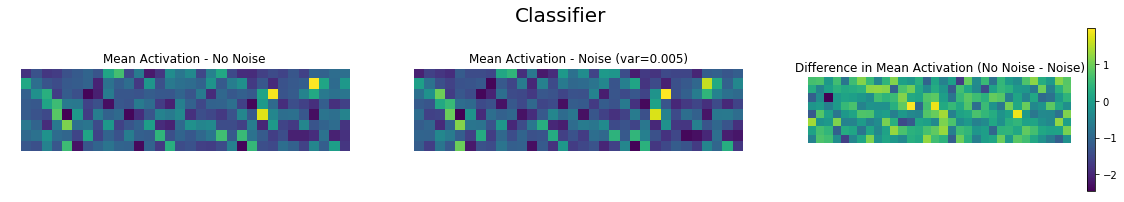

In [323]:
plt.figure(figsize=(20,3))
plt.suptitle('Classifier',fontsize=20)
plt.subplot(1,3,1)
plt.imshow(np.mean(encC,axis=0).reshape((8,32)))
plt.title('Mean Activation - No Noise')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(np.mean(encC_noise,axis=0).reshape((8,32)))
plt.title('Mean Activation - Noise (var=0.005)')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.mean(encC-encC_noise,axis=0).reshape((8,32)))
plt.title('Difference in Mean Activation (No Noise - Noise)')
plt.axis('off')
plt.colorbar()
plt.show()

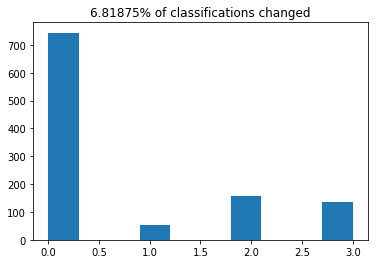

In [189]:
plt.hist(np.where(outC != outC_noise)[1])
plt.title(str(np.where(outC != outC_noise)[1].shape[0]/(outC.shape[0]*4)*100)+'% of classifications changed')
plt.show()

## Load Autoencoder

In [190]:
from keras import backend as k
from keras.models import Sequential,Model
from keras.layers.convolutional import Conv3D, Conv2D, UpSampling2D,Conv2DTranspose
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense,MaxPooling2D,TimeDistributed,Input,concatenate,Flatten,Reshape,LSTM,Lambda

In [191]:
from keras import backend as K
K.clear_session()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

inImg = Input(batch_shape=(None,168, 168, 3),name="input_1")
conv1 = Conv2D(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, name="conv_1")(inImg)
#conv1 = Conv2D(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu,weights=[model_vars['main_graph_0_encoder0/conv_1/kernel:0'],model_vars['main_graph_0_encoder0/conv_1/bias:0']], name="conv_1")(inImg)
print(conv1)
conv2 = Conv2D(filters=32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, name="conv_2")(conv1)
#conv2 = Conv2D(filters=32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu,weights=[model_vars['main_graph_0_encoder0/conv_2/kernel:0'],model_vars['main_graph_0_encoder0/conv_2/bias:0']], name="conv_2")(conv1)
print(conv2)
flat = Reshape((19*19*32,))(conv2)#Flatten()(conv)
print(flat)
dens = Dense(256,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_1")(flat)
#dens = Dense(256,activation=swish,weights=[model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_0/kernel:0'],model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_0/bias:0']], name="dens_1")(flat)
print(dens)
enc = Dense(256,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_2")(dens)
#enc = Dense(256,activation=swish,weights=[model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_1/kernel:0'],model_vars['main_graph_0_encoder0/flat_encoding/main_graph_0_encoder0/hidden_1/bias:0']], name="dens_2")(dens)
print(enc)
de_dens = Dense(20*20*32,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_3")(enc)
print(de_dens)
shaped = Reshape((20, 20, 32))(de_dens)
print(shaped)
de_conv = Conv2DTranspose(filters=16, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, name="deconv_1")(shaped)
print(de_conv)
#de_conv = Conv2DTranspose(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, name="deconv_2")(de_conv)
#print(de_conv)
prediction = Conv2DTranspose(filters=3, kernel_size=[8, 8], strides=[4, 4],padding='same',activation=tf.nn.elu, name="deconv_3")(de_conv)
print(prediction)
model = Model(inputs=inImg, outputs=prediction)

optimizer = tf.train.AdamOptimizer(0.0001)

model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['accuracy','mse'])

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=[model.get_layer('dens_2').output,model.get_layer('deconv_3').output])

Tensor("conv_1/Elu:0", shape=(?, 41, 41, 16), dtype=float32)
Tensor("conv_2/Elu:0", shape=(?, 19, 19, 32), dtype=float32)
Tensor("reshape_1/Reshape:0", shape=(?, 11552), dtype=float32)
Tensor("dens_1/Mul:0", shape=(?, 256), dtype=float32)
Tensor("dens_2/Mul:0", shape=(?, 256), dtype=float32)
Tensor("dens_3/Mul:0", shape=(?, 12800), dtype=float32)
Tensor("reshape_2/Reshape:0", shape=(?, 20, 20, 32), dtype=float32)
Tensor("deconv_1/Elu:0", shape=(?, ?, ?, 16), dtype=float32)
Tensor("deconv_3/Elu:0", shape=(?, ?, ?, 3), dtype=float32)


In [192]:
model.load_weights('./Results/TowerTraining/Recordings/Standard/3999_16.100/autoencoder/aemodelAdam50E.h5')

In [193]:
encAE, outAE = intermediate_layer_model.predict(obs)

In [322]:
encAE_noise, outAE_noise = intermediate_layer_model.predict(noise_imgs)

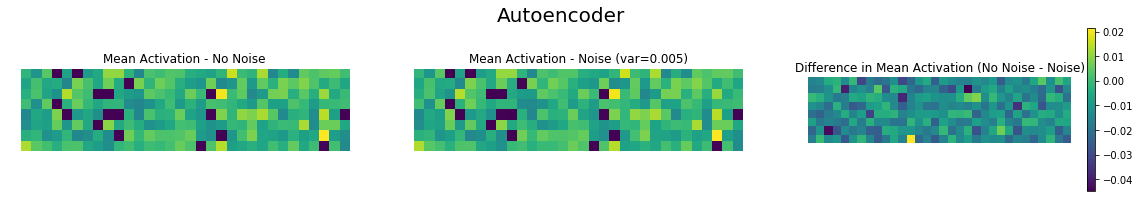

In [324]:
plt.figure(figsize=(20,3))
plt.suptitle('Autoencoder',fontsize=20)
plt.subplot(1,3,1)
plt.imshow(np.mean(encAE,axis=0).reshape((8,32)))
plt.title('Mean Activation - No Noise')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(np.mean(encAE_noise,axis=0).reshape((8,32)))
plt.title('Mean Activation - Noise (var=0.005)')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.mean(encAE-encAE_noise,axis=0).reshape((8,32)))
plt.title('Difference in Mean Activation (No Noise - Noise)')
plt.axis('off')
plt.colorbar()
plt.show()

## Test Different Amounts of Noise

In [325]:
variances = np.array([0.0001,0.0005,0.001,0.005,0.01,0.05,0.1])
noiseLs = np.zeros((variances.shape[0],obs.shape[0],4))
noiseLsC = np.zeros((variances.shape[0],obs.shape[0],4))

perChange = np.zeros(variances.shape[0])
perChangeC = np.zeros(variances.shape[0])
perChangeAE = np.zeros(variances.shape[0])
outChangeAE = np.zeros(variances.shape[0])

EncChange = np.zeros((variances.shape[0],4))
EncChangeC = np.zeros((variances.shape[0],4))
EncChangeAE = np.zeros((variances.shape[0],4))
for i,v in enumerate(variances):
    noise_imgs = random_noise(obs, mode='gaussian', var=v,seed=None, clip=True)

    a_noise,e_noise = test_from_frozen_graph(noise_imgs,'./Results/TowerTraining/models/TowerF4/TowerF4_Baseline-0/LearningBrain/frozen_graph_def.pb')
    a_noise_l = probsToLabels(a_noise)
    noiseLs[i] = a_noise_l
    EncChange[i,0] = np.mean(e-e_noise)
    EncChange[i,1] = np.median(e-e_noise)
    EncChange[i,2] = np.mean(np.abs(e-e_noise))
    EncChange[i,3] = np.median(np.abs(e-e_noise))

    perChange[i] = np.where(actOut != a_noise_l)[1].shape[0]/(actOut.shape[0]*4)*100

    encC_noise,outC_noise = sess.run([encoded_visual,output], feed_dict = {visual_in: noise_imgs})
    noiseLsC[i] = outC_noise
    EncChangeC[i,0] = np.mean(encC-encC_noise)
    EncChangeC[i,1] = np.median(encC-encC_noise)
    EncChangeC[i,2] = np.mean(np.abs(encC-encC_noise))
    EncChangeC[i,3] = np.median(np.abs(encC-encC_noise))

    perChangeC[i] = np.where(outC != outC_noise)[1].shape[0]/(outC.shape[0]*4)*100
    
    encAE_noise, outAE_noise = intermediate_layer_model.predict(noise_imgs)
    outChangeAE[i] = np.mean(outAE-outAE_noise)
    perChangeAE[i] = np.sum(np.abs(outAE-outAE_noise)>0.01)/(np.sum(np.abs(outAE-outAE_noise)>0.01)+np.sum(np.abs(outAE-outAE_noise)<=0.01))
    EncChangeAE[i,0] = np.mean(encAE-encAE_noise)
    EncChangeAE[i,1] = np.median(encAE-encAE_noise)
    EncChangeAE[i,2] = np.mean(np.abs(encAE-encAE_noise))
    EncChangeAE[i,3] = np.median(np.abs(encAE-encAE_noise))

Loading model...
Model loading complete!
loaded
Loading model...
Model loading complete!
loaded
Loading model...
Model loading complete!
loaded
Loading model...
Model loading complete!
loaded
Loading model...
Model loading complete!
loaded
Loading model...
Model loading complete!
loaded
Loading model...
Model loading complete!
loaded


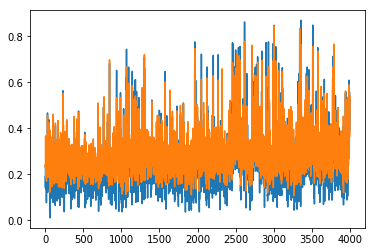

In [271]:
plt.plot(outAE[:,100,100,1])
plt.plot(outAE_noise[:,100,100,1])

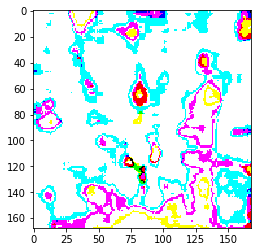

In [258]:
plt.imshow(np.array(np.abs(outAE[10]-outAE_noise[10])>0.01,dtype=float))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


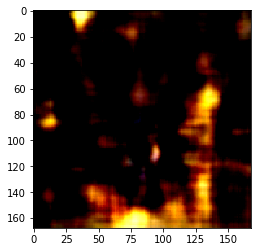

In [268]:
plt.imshow(np.array((outAE[10]-outAE_noise[10])*10,dtype=float))

### Plot Noise Comparison

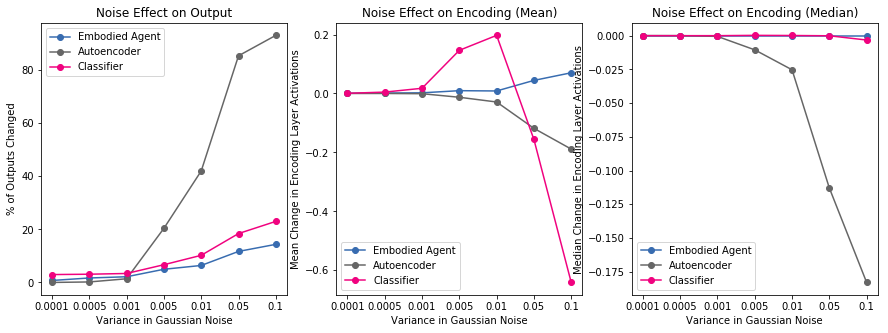

In [311]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(perChange,color=sns.color_palette("Accent", n_colors=8)[4],ls='-',marker='o')
plt.plot(perChangeAE*100,color=sns.color_palette("Accent", n_colors=8)[7],ls='-',marker='o')
plt.plot(perChangeC,color=sns.color_palette("Accent", n_colors=8)[5],ls='-',marker='o')

plt.xticks(np.linspace(0,variances.shape[0]-1,variances.shape[0]),variances)
plt.xlabel('Variance in Gaussian Noise')
plt.ylabel('% of Outputs Changed')
plt.title('Noise Effect on Output')
plt.legend(['Embodied Agent','Autoencoder','Classifier'])
plt.subplot(1,3,2)
plt.plot(EncChange[:,0],color=sns.color_palette("Accent", n_colors=8)[4],ls='-',marker='o')
plt.plot(EncChangeAE[:,0],color=sns.color_palette("Accent", n_colors=8)[7],ls='-',marker='o')
plt.plot(EncChangeC[:,0],color=sns.color_palette("Accent", n_colors=8)[5],ls='-',marker='o')

plt.xticks(np.linspace(0,variances.shape[0]-1,variances.shape[0]),variances)
plt.xlabel('Variance in Gaussian Noise')
plt.ylabel('Mean Change in Encoding Layer Activations')
plt.title('Noise Effect on Encoding (Mean)')
plt.legend(['Embodied Agent','Autoencoder','Classifier'])
plt.subplot(1,3,3)
plt.plot(EncChange[:,1],color=sns.color_palette("Accent", n_colors=8)[4],ls='-',marker='o')
plt.plot(EncChangeAE[:,1],color=sns.color_palette("Accent", n_colors=8)[7],ls='-',marker='o')
plt.plot(EncChangeC[:,1],color=sns.color_palette("Accent", n_colors=8)[5],ls='-',marker='o')

plt.xticks(np.linspace(0,variances.shape[0]-1,variances.shape[0]),variances)
plt.xlabel('Variance in Gaussian Noise')
plt.ylabel('Median Change in Encoding Layer Activations')
plt.title('Noise Effect on Encoding (Median)')
plt.legend(['Embodied Agent','Autoencoder','Classifier'])
plt.show()
#plt.savefig(figure_path+'Robustness.eps', bbox_inches='tight', dpi=300)

### Plot Noise Comparison (Absolute)

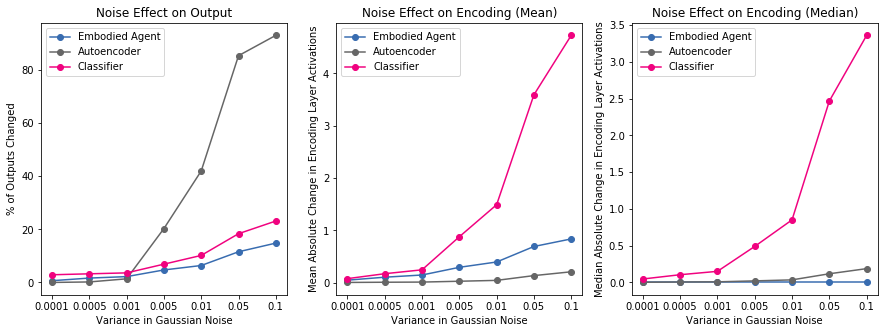

In [328]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(perChange,color=sns.color_palette("Accent", n_colors=8)[4],ls='-',marker='o')
plt.plot(perChangeAE*100,color=sns.color_palette("Accent", n_colors=8)[7],ls='-',marker='o')
plt.plot(perChangeC,color=sns.color_palette("Accent", n_colors=8)[5],ls='-',marker='o')

plt.xticks(np.linspace(0,variances.shape[0]-1,variances.shape[0]),variances)
plt.xlabel('Variance in Gaussian Noise')
plt.ylabel('% of Outputs Changed')
plt.title('Noise Effect on Output')
plt.legend(['Embodied Agent','Autoencoder','Classifier'])
plt.subplot(1,3,2)
plt.plot(EncChange[:,2],color=sns.color_palette("Accent", n_colors=8)[4],ls='-',marker='o')
plt.plot(EncChangeAE[:,2],color=sns.color_palette("Accent", n_colors=8)[7],ls='-',marker='o')
plt.plot(EncChangeC[:,2],color=sns.color_palette("Accent", n_colors=8)[5],ls='-',marker='o')

plt.xticks(np.linspace(0,variances.shape[0]-1,variances.shape[0]),variances)
plt.xlabel('Variance in Gaussian Noise')
plt.ylabel('Mean Absolute Change in Encoding Layer Activations')
plt.title('Noise Effect on Encoding (Mean)')
plt.legend(['Embodied Agent','Autoencoder','Classifier'])
plt.subplot(1,3,3)
plt.plot(EncChange[:,3],color=sns.color_palette("Accent", n_colors=8)[4],ls='-',marker='o')
plt.plot(EncChangeAE[:,3],color=sns.color_palette("Accent", n_colors=8)[7],ls='-',marker='o')
plt.plot(EncChangeC[:,3],color=sns.color_palette("Accent", n_colors=8)[5],ls='-',marker='o')

plt.xticks(np.linspace(0,variances.shape[0]-1,variances.shape[0]),variances)
plt.xlabel('Variance in Gaussian Noise')
plt.ylabel('Median Absolute Change in Encoding Layer Activations')
plt.title('Noise Effect on Encoding (Median)')
plt.legend(['Embodied Agent','Autoencoder','Classifier'])
#plt.show()
plt.savefig(figure_path+'RobustnessAbs.png', bbox_inches='tight', dpi=300)

### Plot Noise Examples

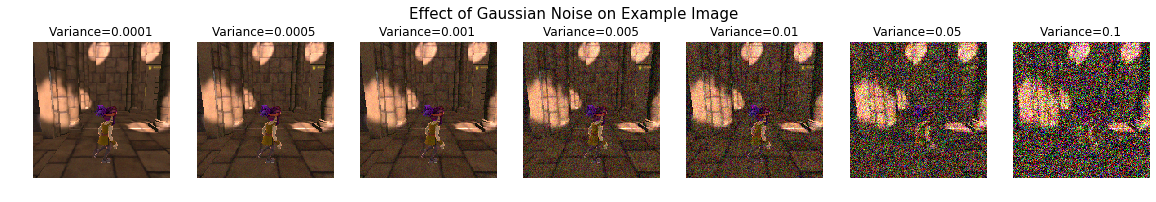

In [308]:
plt.figure(figsize=(20,3))
plt.suptitle('Effect of Gaussian Noise on Example Image',fontsize=15)
for i in range(variances.shape[0]):
    plt.subplot(1,variances.shape[0],i+1)
    noise_img = random_noise(obs[5], mode='gaussian', var=variances[i],seed=None, clip=True)
    plt.imshow(noise_img)
    plt.axis('off')
    plt.title('Variance='+str(variances[i]))
#plt.show()
plt.savefig(figure_path+'NoiseExample.eps', bbox_inches='tight', dpi=300)

### Plot Autoencoder Output Example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


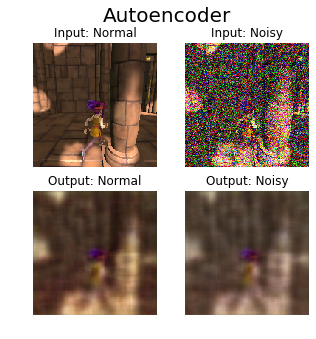

In [310]:
plt.figure(figsize=(5,5))
plt.suptitle('Autoencoder',fontsize=20)
plt.subplot(2,2,1)
plt.imshow(obs[10])
plt.title('Input: Normal')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(noise_imgs[10])
plt.title('Input: Noisy')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(outAE[10])
plt.title('Output: Normal')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(outAE_noise[10])
plt.title('Output: Noisy')
plt.axis('off')
#plt.show()
plt.savefig(figure_path+'NoiseAE.eps', bbox_inches='tight', dpi=300)